<a href="https://colab.research.google.com/github/npr99/Archive/blob/master/IN_CORE_1dv2_Lumberton_EstimateAddressPoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explore Building Inventory to Find Residential Structures 
Steps required to make the Probabilistic Housing Unit Allocation work.

Building inventory data now includes blockid, placeid, puma data
With all of this information it should be possible to explore the building inventory data to find most likely residential structures.

With a good count of structures the number of housing units estimated by the Census can be distributed to building inventory.

To Do:
1. Read in cleaned building inventory data with census block data
2. Identify Residential Structures
3. Count residential structures by block
4. Estimate the number of residential housing units (addressp points) in each structure

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import math as math
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely
import folium as fm # folium has more dynamic maps - but requires internet connection
import os # For saving output to path

C:\Users\nathanael99\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
# Display versions being used - important information for replication
import sys
print("Python Version     ", sys.version)
print("numpy version:     ", np.__version__)
print("geopandas version: ", gpd.__version__)
print("pandas version:    ", pd.__version__)
print("shapely version:   ", shapely.__version__)
print("folium version:    ", fm.__version__)

Python Version      3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:37:01) [MSC v.1916 64 bit (AMD64)]
numpy version:      1.20.1
geopandas version:  0.9.0
pandas version:     0.24.2
shapely version:    1.7.1
folium version:     0.9.1


In [ ]:
# Store Program Name for output files to have the same name
programname = "IN-CORE_1dv2_Lumberton_EstimateAddressPoints_2021-04-15"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

## Obtain data from previous program - Building Inventory with Parcel ID
The previous program (IN-CORE_1cv2_Joplin_CleanBuildingInventory_2019) combined parcel data with the building inventory. With this information residential buildings can be identified with greater certaintity.


In [ ]:
source_program = "IN-CORE_1cv2_Lumberton_CleanBuildingInventory_2021-04-15"
building_csv = source_program+"/"+source_program+"_EPSG4326.csv"
building_df = pd.read_csv(building_csv)
building_gdf = gpd.GeoDataFrame(building_df)
building_gdf.head()

,Unnamed: 0,guid,BLOCKID10,STATEFP10,COUNTYFP10,TRACTCE10,PUMGEOID10,PUMNAME10,PLCGEOID10,PLCNAME10,...,appr_tot,year_built,lhsm_elev,g_elev,age_group,geometry,HOUSING10,apcount,popdiff,POP10
0,0,2d32aeff-7b75-47e6-b7a5-4f4adca4b021,371559613011113,37.0,155.0,961301.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,NaN,NaN,NaN,NaN,NaN,POINT (-78.99633432765292 34.6543576103806),84.0,84.0,0.0,115.0
1,1,78e8556b-15b3-45e9-a72d-dba53a188b8d,371559607022057,37.0,155.0,960702.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,NaN,NaN,NaN,NaN,NaN,POINT (-79.01851581373739 34.64057297320472),0.0,0.0,0.0,0.0
2,2,6b481629-e0c6-48f6-b1ce-d57f65d35cb6,371559608021059,37.0,155.0,960802.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,NaN,NaN,NaN,NaN,NaN,POINT (-79.0284731543055 34.60277281976215),1.0,1.0,0.0,1.0
3,3,a6875194-ad6b-4061-9855-fe8a8b0f5ba6,371559608012025,37.0,155.0,960801.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,NaN,NaN,NaN,NaN,NaN,POINT (-79.0596674706708 34.6199873170208),10.0,10.0,0.0,22.0
4,4,3928ae4d-4450-427f-8fc3-2294d36879f8,371559615004008,37.0,155.0,961500.0,3704900.0,"Columbus, Bladen & Robeson (East) Counties PUMA",NaN,NaN,...,NaN,1988.0,NaN,NaN,3.0,POINT (-78.9465927441201 34.55213189040023),5.0,5.0,0.0,12.0


In [ ]:
# Check Columns
cols = [col for col in building_gdf]
cols

['Unnamed: 0',
 'guid',
 'BLOCKID10',
 'STATEFP10',
 'COUNTYFP10',
 'TRACTCE10',
 'PUMGEOID10',
 'PUMNAME10',
 'PLCGEOID10',
 'PLCNAME10',
 'ffe_elev',
 'archetype',
 'parid',
 'struct_typ',
 'no_stories',
 'a_stories',
 'b_stories',
 'bsmt_type',
 'sq_foot',
 'gsq_foot',
 'occ_type',
 'occ_detail',
 'major_occ',
 'broad_occ',
 'repl_cst',
 'str_cst',
 'nstra_cst',
 'nstrd_cst',
 'dgn_lvl',
 'cont_val',
 'efacility',
 'dwell_unit',
 'str_typ2',
 'occ_typ2',
 'strctid',
 'appr_bldg',
 'appr_land',
 'appr_tot',
 'year_built',
 'lhsm_elev',
 'g_elev',
 'age_group',
 'geometry',
 'HOUSING10',
 'apcount',
 'popdiff',
 'POP10']

In [ ]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.wkt import loads

building_gdf['geometry'] = building_gdf['geometry'].apply(lambda x: loads(x))
building_gdf['geometry'].geom_type.describe()

count     20091
unique        1
top       Point
freq      20091
dtype: object

In [ ]:
# Geodata frame requires geometry and CRS to be set
building_gdf = building_gdf.set_geometry(building_gdf['geometry'])
building_gdf.crs = {'init':'epsg:4326'}

In [ ]:
# Check Unique IDs and Foreign Keys
building_gdf.guid.describe()

count                                    20091
unique                                   20091
top       6021bb69-0f48-4569-8878-154e66711921
freq                                         1
Name: guid, dtype: object

## Limit Number of Buildings to Most Likely Residential Structures
Based on archetype data make assumptions about buildings that might be residential buildings. 

The goal is to reduce the number of buildings that are counted as residential address points and limit the allocation of housing units to buildings that are commercial.

## Explore Variables Related To Residential Data
- archetype
- dwell_unit - missing for all observations - can be filled in with address point inventory
- occ_type - Omar says this is from HAZUS

In [ ]:
building_gdf[['archetype','apcount','POP10']].groupby(['archetype']).sum()

,apcount,POP10
archetype,,
0,299.0,608.0
1,311395.0,815453.0
2,339593.0,846766.0
3,10785.0,30482.0
4,42953.0,104002.0
5,15075.0,36293.0
6,124.0,318.0
7,21.0,111.0
8,27.0,57.0


In [ ]:
building_gdf.dwell_unit.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: dwell_unit, dtype: float64

In [ ]:
building_gdf.occ_type.describe()

count     20088
unique      143
top        2245
freq       6596
Name: occ_type, dtype: object

## Details on building achetypes
Nofal and van de Lindt (2020) Minimal Building Flood Fragility and Loss Function Portfolio for Resilience Analysis at the Community Level https://doi.org/10.3390/w12082277

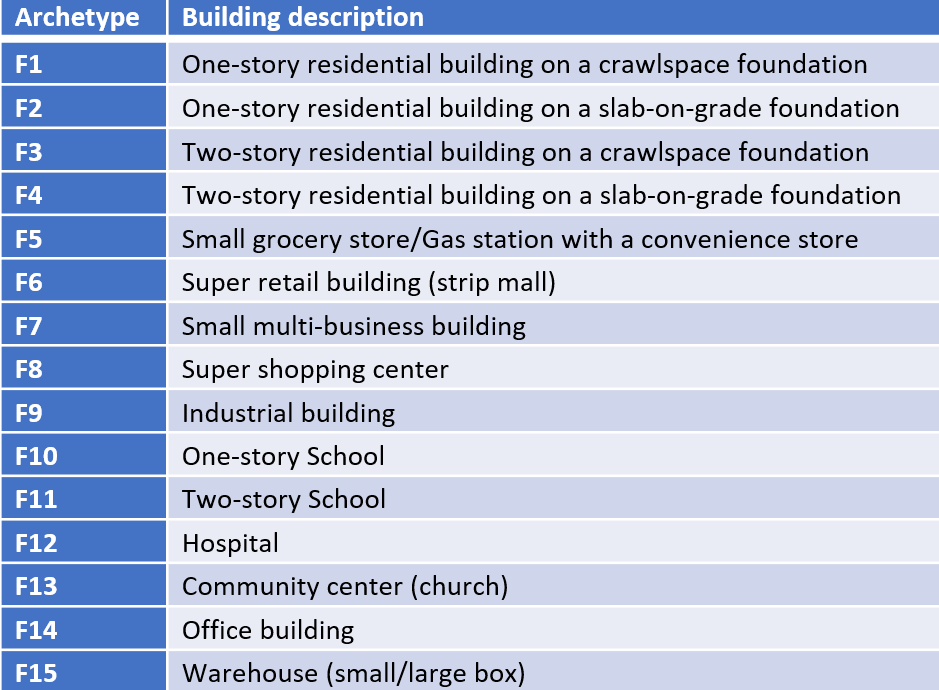

In [ ]:
building_gdf['residentialAP1'] = 0
building_gdf['residentialAP1'].label = "Residential Address Point Round 1"
building_gdf['residentialAP1'].note = "Residential Address Point - first attempt to assign residential address points to buildings"

In [ ]:
building_gdf.loc[building_gdf['archetype'] == 1,'residentialAP1'] = 1
building_gdf.loc[building_gdf['archetype'] == 2,'residentialAP1'] = 1
building_gdf.loc[building_gdf['archetype'] == 3,'residentialAP1'] = 1
building_gdf.loc[building_gdf['archetype'] == 4,'residentialAP1'] = 1
pd.crosstab(building_gdf['archetype'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,Total
archetype,,,
0,25,0,25
1,0,6070,6070
2,0,10273,10273
3,0,249,249
4,0,1391,1391
5,1060,0,1060
6,9,0,9
7,10,0,10
8,14,0,14


## Assume all buildings with an area of less than 300 square feet is has no address point
The building footprint data includes many small buildings that could be detached garages or sheds.

In [ ]:
building_gdf.gsq_foot.describe()

count     20091.000000
mean       2835.945050
std       10121.651451
min           0.000000
25%        1250.000000
50%        1706.000000
75%        2439.000000
max      471625.000000
Name: gsq_foot, dtype: float64

In [ ]:
# remove small buildings from residential bulding list
building_gdf.loc[building_gdf['gsq_foot'] < 300,'residentialAP1'] = 0
pd.crosstab(building_gdf['archetype'], building_gdf['residentialAP1'])

residentialAP1,0,1
archetype,,
0,25,0
1,0,6070
2,15,10258
3,0,249
4,0,1391
5,1060,0
6,9,0
7,10,0
8,14,0


### Extend small square footage to buildings assumed to have 2 to 3 address points

In [ ]:
# Look at shape area divided by the number of address points
building_gdf['gsq_foot_by_AP'] = building_gdf['gsq_foot'] / building_gdf['residentialAP1']
building_gdf['gsq_foot_by_AP'].describe()

count    20088.00
mean          inf
std           NaN
min        355.00
25%       1263.00
50%       1745.00
75%       2595.25
max           inf
Name: gsq_foot_by_AP, dtype: float64

In [ ]:
building_gdf['gsq_foot_by_AP'].loc[building_gdf['gsq_foot_by_AP'] < 300 ].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: gsq_foot_by_AP, dtype: float64

In [ ]:
# remove small buildings from residential bulding list
building_gdf.loc[building_gdf['gsq_foot_by_AP'] < 300,'residentialAP1'] = 0
pd.crosstab(building_gdf['archetype'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,Total
archetype,,,
0,25,0,25
1,0,6070,6070
2,15,10258,10273
3,0,249,249
4,0,1391,1391
5,1060,0,1060
6,9,0,9
7,10,0,10
8,14,0,14


In [ ]:
# If Address Point Count (Housing10 + Group Quarters) from Census is 0 then Residential Address Point is also 0
building_gdf.loc[building_gdf['apcount'] == 0,'residentialAP1'] = 0
pd.crosstab(building_gdf['archetype'], building_gdf['residentialAP1'], margins=True, margins_name="Total")

residentialAP1,0,1,Total
archetype,,,
0,25,0,25
1,103,5967,6070
2,84,10189,10273
3,0,249,249
4,5,1386,1391
5,1060,0,1060
6,9,0,9
7,10,0,10
8,14,0,14


Text(0, 0.5, 'Residential Address Point Count')

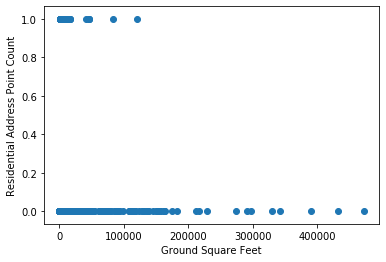

In [ ]:
# Compare Residential Address Point Count to Square Footage
x = building_gdf['gsq_foot']
y = building_gdf['residentialAP1']
plt.scatter(x, y)
plt.xlabel("Ground Square Feet")
plt.ylabel("Residential Address Point Count")

In [ ]:
building_gdf['gsq_foot'].groupby(building_gdf['residentialAP1']).describe()

,count,mean,std,min,25%,50%,75%,max
residentialAP1,,,,,,,,
0,2300.0,10256.699130,28527.119953,0.0,1928.25,3610.5,7402.75,471625.0
1,17791.0,1876.598505,1576.763786,355.0,1221.00,1631.0,2249.00,120416.0


## Sum Residential Addresspoints (first attempt) by blockid

In [ ]:
# sum Buildings over the column BLOCKID.
# https://www.geeksforgeeks.org/python-pandas-dataframe-sum/
block_rap1_gdf = building_gdf[['BLOCKID10','residentialAP1']]
block_rap1_gdf['bldgcount'] = 1
block_rap1_gdf_sum = block_rap1_gdf.groupby(['BLOCKID10']).sum()
block_rap1_gdf_sum.head()

C:\Users\nathanael99\AppData\Local\Continuum\anaconda3\envs\pyincoreEnv20210301\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,residentialAP1,bldgcount
BLOCKID10,,
371559601024055,1,1
371559604022066,6,6
371559605031030,17,17
371559605031031,12,12
371559605031036,6,16


In [ ]:
block_rap1_gdf_sum['residentialAP1'].describe()

count    1572.000000
mean       11.317430
std        17.534954
min         0.000000
25%         2.000000
50%         6.000000
75%        14.000000
max       205.000000
Name: residentialAP1, dtype: float64

## Merge Sum of Estimated Sum of Address Points with Census Block Data

In [ ]:
# Read in Census Block Data
source_program = 'IN-CORE_1av2_Lumberton_CleanBlockData_2021-04-15'
census_blocks_csv = source_program+"/"+source_program+"EPSG4269.csv"
census_blocks_df = pd.read_csv(census_blocks_csv)
census_blocks_df.head()

,Unnamed: 0,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,...,blockid,tothupoints,popcount,HU100,POP100,popdiff,PLCGEOID10,PLCNAME10,PUMGEOID10,PUMNAME10
0,0,37,155,961900,2028,371559619002028,N,14,52,"POLYGON ((-79.22246 34.458838, -79.222528 34.4...",...,371559619002028,14,51,14,52,1,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA
1,1,37,155,961900,2054,371559619002054,N,1,3,"POLYGON ((-79.179851 34.40192, -79.180036 34.4...",...,371559619002054,1,3,1,3,0,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA
2,2,37,155,961700,2069,371559617002069,N,41,99,"POLYGON ((-79.172814 34.480917, -79.172749 34....",...,371559617002069,41,99,41,99,0,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA
3,3,37,155,961700,2065,371559617002065,N,6,22,"POLYGON ((-79.15764299999999 34.503279, -79.15...",...,371559617002065,6,21,6,22,1,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA
4,4,37,155,961700,2058,371559617002058,N,19,55,"POLYGON ((-79.15830299999999 34.497355, -79.15...",...,371559617002058,19,55,19,55,0,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA


In [ ]:
# Merge Sum of Residential Address Points with Census Counts
census_blocks_df_rap1 = pd.merge(census_blocks_df, block_rap1_gdf_sum,
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')

### Error Check 1 - Are there Blocks in Joplin that have Housing Units by the Estimated Number of Housing Units is 0 or Missing?

Text(0, 0.5, 'Housing Unit Count')

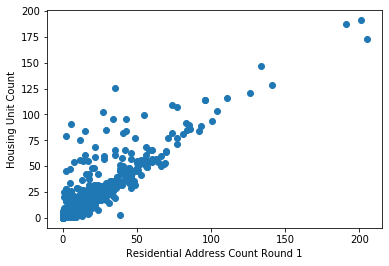

In [ ]:
# Compare Bldg Count to Housing 10
x = census_blocks_df_rap1['residentialAP1']
y = census_blocks_df_rap1['tothupoints']
plt.scatter(x, y)
plt.xlabel("Residential Address Count Round 1")
plt.ylabel("Housing Unit Count")

## Error Check Options
### Two Areas to Focus on Inside Joplin Area and Outside Joplin Area
#### For places outside of Joplin Census Boundary there could be Buildings


In [ ]:
census_blocks_df_rap1.loc[census_blocks_df_rap1['PLCNAME10'] == "Lumberton",'Lumberton'] = "Lumberton"
census_blocks_df_rap1.loc[census_blocks_df_rap1['PLCNAME10'] != "Lumberton",'Lumberton'] = "Not Lumberton"

In [ ]:
def block_error_check_addresspoints(census_blocks_df, expected_count, estimated_count,building_count, ErrorCheck):
    # Create Error Varaible
    census_blocks_df[ErrorCheck] = "0. Not Checked"

    basecondition = (census_blocks_df[ErrorCheck] == "0. Not Checked")
    census_blocks_df.loc[(census_blocks_df[expected_count].isna())
                         & basecondition, ErrorCheck] = "1. HU=0"
    census_blocks_df.loc[(census_blocks_df[expected_count] == census_blocks_df[estimated_count])
                         & basecondition, ErrorCheck] = "2. HU=AP"
    census_blocks_df.loc[(census_blocks_df[expected_count] < census_blocks_df[estimated_count])
                         & basecondition, ErrorCheck] = "3. HU<AP"
    census_blocks_df.loc[(census_blocks_df[expected_count] > census_blocks_df[estimated_count])
                         & basecondition, ErrorCheck] = "4. HU>AP"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[estimated_count] == 0)
                         & basecondition, ErrorCheck] = "5. HU > 0, AP = 0"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[estimated_count].isna()) & 
                         (census_blocks_df[building_count] > 0)
                         , ErrorCheck] = "6. HU > 0, AP = Missing, But buildings present"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[estimated_count].isna())
                         , ErrorCheck] = "7. HU > 0, AP = Missing"
    census_blocks_df.loc[(census_blocks_df[expected_count] > 0) & (census_blocks_df[building_count].isna())
                         , ErrorCheck] = "8. HU > 0, Building Count = Missing"
    census_blocks_df.loc[(census_blocks_df[expected_count].isna()) & (census_blocks_df[building_count].isna())
                         , ErrorCheck] = "9. HU = 0, Building Count = Missing"
    
block_error_check_addresspoints(census_blocks_df_rap1,'tothupoints','residentialAP1','bldgcount','ErrorCheck1')
pd.crosstab(census_blocks_df_rap1['ErrorCheck1'], census_blocks_df_rap1['Lumberton'],
            margins=True, margins_name="Total")

Lumberton,Lumberton,Not Lumberton,Total
ErrorCheck1,,,
0. Not Checked,181,1295,1476
2. HU=AP,406,214,620
3. HU<AP,128,308,436
4. HU>AP,302,193,495
"5. HU > 0, AP = 0",17,4,21
"8. HU > 0, Building Count = Missing",13,2738,2751
Total,1047,4752,5799


In [ ]:
# look at estimated Address Points by Error
census_blocks_df_rap1['residentialAP1'].groupby(census_blocks_df_rap1['ErrorCheck1']).describe()

,count,mean,std,min,25%,50%,75%,max
ErrorCheck1,,,,,,,,
0. Not Checked,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2. HU=AP,620.0,4.861290,8.835974,0.0,0.00,2.0,7.0,86.0
3. HU<AP,436.0,18.197248,23.825469,2.0,5.75,11.0,21.0,205.0
4. HU>AP,495.0,13.824242,16.562097,1.0,4.00,8.0,17.0,134.0
"5. HU > 0, AP = 0",21.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
"8. HU > 0, Building Count = Missing",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# For the 21 blocks with 0 address points and HU greater than 0 look at adding address points
displaycols = ['BLOCKID10','COUNTYFP10','PLCNAME10','residentialAP1','tothupoints','bldgcount','ErrorCheck1']
condition = (census_blocks_df_rap1['ErrorCheck1'] == "5. HU > 0, AP = 0") & (census_blocks_df_rap1['Lumberton']=="Lumberton")
census_blocks_df_rap1[displaycols].loc[condition]

,BLOCKID10,COUNTYFP10,PLCNAME10,residentialAP1,tothupoints,bldgcount,ErrorCheck1
509,371559608012132,155,Lumberton,0.0,1,1.0,"5. HU > 0, AP = 0"
510,371559610003045,155,Lumberton,0.0,4,9.0,"5. HU > 0, AP = 0"
631,371559612001014,155,Lumberton,0.0,1,2.0,"5. HU > 0, AP = 0"
686,371559608011036,155,Lumberton,0.0,2,11.0,"5. HU > 0, AP = 0"
823,371559610003075,155,Lumberton,0.0,1,2.0,"5. HU > 0, AP = 0"
944,371559612001025,155,Lumberton,0.0,1,1.0,"5. HU > 0, AP = 0"
1021,371559610001034,155,Lumberton,0.0,1,2.0,"5. HU > 0, AP = 0"
1204,371559611002016,155,Lumberton,0.0,2,5.0,"5. HU > 0, AP = 0"
1848,371559612001019,155,Lumberton,0.0,4,15.0,"5. HU > 0, AP = 0"
2012,371559610003055,155,Lumberton,0.0,1,3.0,"5. HU > 0, AP = 0"


In [ ]:
census_blocks_df_rap1['DiffCount1'] = census_blocks_df_rap1['tothupoints'] - census_blocks_df_rap1['residentialAP1']
census_blocks_df_rap1 = census_blocks_df_rap1.rename(index=str, columns={
    "residentialAP1": "residentialAP1_sum", 
    "bldgcount": "bldgcount1_sum"})

In [ ]:
# Merge Block level data with building level data
keepcolumns = ['BLOCKID10','residentialAP1_sum','bldgcount1_sum','DiffCount1','ErrorCheck1']

building_gdf_round2 = pd.merge(building_gdf, census_blocks_df_rap1[keepcolumns], 
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
# Convert Pandas Data Frame from Merge to Geodataframe
building_gdf_round2 = gpd.GeoDataFrame(building_gdf_round2, crs=building_gdf.crs)
# Check Merge to make sure all buildings are in the dataset
building_gdf_round2['guid'].describe()

count                                    20091
unique                                   20091
top       6021bb69-0f48-4569-8878-154e66711921
freq                                         1
Name: guid, dtype: object

## Distribute Missing Address Points to Buildings Based on Area
\begin{equation*}
\frac{Area_k}{\left( \sum_{k=1}^n Area_k \right)}*DiffCount_i
\end{equation*}

In [ ]:
# For Error Check = 5. HU > 0, AP = 0 - Make Each Building that is in the block a residential address point
pd.crosstab(building_gdf_round2['ErrorCheck1'], building_gdf_round2['residentialAP1'],
            margins=True, margins_name="Total")

residentialAP1,0,1,Total
ErrorCheck1,,,
2. HU=AP,1052,3014,4066
3. HU<AP,610,7934,8544
4. HU>AP,547,6843,7390
"5. HU > 0, AP = 0",91,0,91
Total,2300,17791,20091


In [ ]:
# For Error Code 5 Make each Building a Residential Building
building_gdf_round2.loc[(building_gdf_round2['ErrorCheck1'] == "5. HU > 0, AP = 0"),'residentialAP1']=1
pd.crosstab(building_gdf_round2['ErrorCheck1'], building_gdf_round2['residentialAP1'],
            margins=True, margins_name="Total")

residentialAP1,0,1,Total
ErrorCheck1,,,
2. HU=AP,1052,3014,4066
3. HU<AP,610,7934,8544
4. HU>AP,547,6843,7390
"5. HU > 0, AP = 0",0,91,91
Total,2209,17882,20091


In [ ]:
# Calcuate sum of Residential Area By Block
building_gdf_round2['Res_Area'] = 0
building_gdf_round2.loc[(building_gdf_round2['residentialAP1']>=1), 'Res_Area'] = building_gdf_round2['gsq_foot']
building_gdf_round2_area = building_gdf_round2[['BLOCKID10','Res_Area']]
building_gdf_round2_area.Res_Area.describe()

count     20091.000000
mean       1707.211786
std        2197.291807
min           0.000000
25%        1082.000000
50%        1520.000000
75%        2158.000000
max      138413.000000
Name: Res_Area, dtype: float64

In [ ]:
building_gdf_round2_area_sum = building_gdf_round2_area.groupby(['BLOCKID10']).sum()
building_gdf_round2_area_sum = building_gdf_round2_area_sum.rename(columns={"Res_Area": "Sum_Res_Area"})
building_gdf_round2_area_sum.head()

,Sum_Res_Area
BLOCKID10,
371559601024055,2139
371559604022066,12271
371559605031030,67561
371559605031031,18044
371559605031036,17521


In [ ]:
building_gdf_round2_v2 = pd.merge(building_gdf_round2, building_gdf_round2_area_sum, 
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='outer')
# Convert Pandas Data Frame from Merge to Geodataframe
building_gdf_round2_v2 = gpd.GeoDataFrame(building_gdf_round2_v2, crs=building_gdf.crs)
building_gdf_round2_v2['guid'].describe()

count                                    20091
unique                                   20091
top       6021bb69-0f48-4569-8878-154e66711921
freq                                         1
Name: guid, dtype: object

In [ ]:
# Calculate Number of Address Points Each Building Should Have based on Housing Unit Count Difference
building_gdf_round2_v2['residentialAP2'] = (building_gdf_round2_v2['Res_Area'] / building_gdf_round2_v2['Sum_Res_Area']) * building_gdf_round2_v2['DiffCount1'] 
building_gdf_round2_v2['residentialAP2'].describe()

count    19304.000000
mean         0.097078
std          0.837212
min         -2.865553
25%         -0.093886
50%          0.000000
75%          0.088938
max         40.296565
Name: residentialAP2, dtype: float64

### Estimate new Housing Unit Count in Building
Using the distributed difference in address points, round the value and add to the intial estimate.

For blocks where the housing unit and address points are equal (Error 2) or for blocks where the number of address points is greater than the number of Housing Units (Error 3) use the estimate from Round 1.

In [ ]:
building_gdf_round2_v2['residentialAP2v2'] = round(building_gdf_round2_v2['residentialAP2'],0) + building_gdf_round2_v2['residentialAP1']
# If Round 1 had a match between Address Points and Housing Units use Round 1
building_gdf_round2_v2.loc[(building_gdf_round2_v2['ErrorCheck1'] == "2. HU=AP"),'residentialAP2v2'] = building_gdf_round2_v2['residentialAP1']
# If Round 1 had a more Address Points than Housing Units Use Round 1
building_gdf_round2_v2.loc[(building_gdf_round2_v2['ErrorCheck1'] == "3. HU<AP"),'residentialAP2v2'] = building_gdf_round2_v2['residentialAP1']

# If Estiamted number of Census Housing Units is 0 make AP 0
building_gdf_round2_v2.loc[(building_gdf_round2_v2['ErrorCheck1'] == "1. HU=0"),'residentialAP2v2'] = 0

pd.crosstab(building_gdf_round2_v2['residentialAP2v2'], building_gdf_round2_v2['ErrorCheck1'],
            margins=True, margins_name="Total")

ErrorCheck1,2. HU=AP,3. HU<AP,4. HU>AP,"5. HU > 0, AP = 0",Total
residentialAP2v2,,,,,
0.0,1052,610,547,0,2209
1.0,3014,7934,5392,67,16407
2.0,0,0,1027,21,1048
3.0,0,0,211,1,212
4.0,0,0,83,0,83
5.0,0,0,39,0,39
6.0,0,0,32,0,32
7.0,0,0,23,0,23
8.0,0,0,9,1,10


## Sum Residential Addresspoints (second attempt) by blockid

In [ ]:
# sum Buildings over the column BLOCKID.
# https://www.geeksforgeeks.org/python-pandas-dataframe-sum/
block_rap2_gdf = building_gdf_round2_v2[['BLOCKID10','residentialAP2v2']]
block_rap2_gdf['bldgcountv2'] = 1
block_rap2_gdf_sum = block_rap2_gdf.groupby(['BLOCKID10']).sum()
block_rap2_gdf_sum.head()

C:\Users\nathanael99\AppData\Local\Continuum\anaconda3\envs\pyincoreEnv20210301\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,residentialAP2v2,bldgcountv2
BLOCKID10,,
371559601024055,20.0,1
371559604022066,6.0,6
371559605031030,17.0,17
371559605031031,23.0,12
371559605031036,12.0,16


In [ ]:
block_rap2_gdf_sum['residentialAP2v2'].describe()

count    1572.000000
mean       13.059796
std        19.472816
min         0.000000
25%         2.000000
50%         7.000000
75%        15.000000
max       205.000000
Name: residentialAP2v2, dtype: float64

## Error Check Round 2

In [ ]:
census_blocks_df_rap1.head()

,Unnamed: 0,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,...,popdiff,PLCGEOID10,PLCNAME10,PUMGEOID10,PUMNAME10,residentialAP1_sum,bldgcount1_sum,Lumberton,ErrorCheck1,DiffCount1
0,0,37,155,961900,2028,371559619002028,N,14,52,"POLYGON ((-79.22246 34.458838, -79.222528 34.4...",...,1,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA,NaN,NaN,Not Lumberton,"8. HU > 0, Building Count = Missing",NaN
1,1,37,155,961900,2054,371559619002054,N,1,3,"POLYGON ((-79.179851 34.40192, -79.180036 34.4...",...,0,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA,NaN,NaN,Not Lumberton,"8. HU > 0, Building Count = Missing",NaN
2,2,37,155,961700,2069,371559617002069,N,41,99,"POLYGON ((-79.172814 34.480917, -79.172749 34....",...,0,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA,NaN,NaN,Not Lumberton,"8. HU > 0, Building Count = Missing",NaN
3,3,37,155,961700,2065,371559617002065,N,6,22,"POLYGON ((-79.15764299999999 34.503279, -79.15...",...,1,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA,NaN,NaN,Not Lumberton,"8. HU > 0, Building Count = Missing",NaN
4,4,37,155,961700,2058,371559617002058,N,19,55,"POLYGON ((-79.15830299999999 34.497355, -79.15...",...,0,NaN,NaN,3705100,Robeson County (West)--Lumberton City PUMA,NaN,NaN,Not Lumberton,"8. HU > 0, Building Count = Missing",NaN


In [ ]:
census_blocks_df_rap1['BLOCKID10'].describe()

count    5.799000e+03
mean     3.715596e+14
std      6.468066e+06
min      3.715596e+14
25%      3.715596e+14
50%      3.715596e+14
75%      3.715596e+14
max      3.715596e+14
Name: BLOCKID10, dtype: float64

In [ ]:
# Merge Sum of Residential Address Points with Census Counts
census_blocks_df_rap2 = pd.merge(census_blocks_df_rap1, block_rap2_gdf_sum,
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
census_blocks_df_rap2['BLOCKID10'].describe()

count    5.799000e+03
mean     3.715596e+14
std      6.468066e+06
min      3.715596e+14
25%      3.715596e+14
50%      3.715596e+14
75%      3.715596e+14
max      3.715596e+14
Name: BLOCKID10, dtype: float64

## Error Check 2 - Are there Blocks in Joplin that have Housing Units by the Estimated Number of Housing Units is 0 or Missing?

Text(0, 0.5, 'Housing Unit Count')

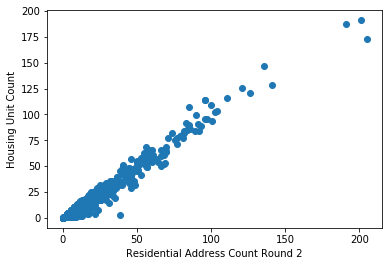

In [ ]:
# Compare Bldg Count to Housing 10
x = census_blocks_df_rap2['residentialAP2v2']
y = census_blocks_df_rap2['tothupoints']
plt.scatter(x, y)
plt.xlabel("Residential Address Count Round 2")
plt.ylabel("Housing Unit Count")

## Error Check Options - Round 2


In [ ]:
block_error_check_addresspoints(census_blocks_df_rap2,'tothupoints','residentialAP2v2','bldgcountv2','ErrorCheck2')
pd.crosstab(census_blocks_df_rap2['ErrorCheck1'], census_blocks_df_rap2['ErrorCheck2'], margins=True, margins_name="Total")

ErrorCheck2,0. Not Checked,2. HU=AP,3. HU<AP,4. HU>AP,"5. HU > 0, AP = 0","8. HU > 0, Building Count = Missing",Total
ErrorCheck1,,,,,,,
0. Not Checked,1476,0,0,0,0,0,1476
2. HU=AP,0,620,0,0,0,0,620
3. HU<AP,0,0,436,0,0,0,436
4. HU>AP,0,133,46,316,0,0,495
"5. HU > 0, AP = 0",0,0,20,0,1,0,21
"8. HU > 0, Building Count = Missing",0,0,0,0,0,2751,2751
Total,1476,753,502,316,1,2751,5799


In [ ]:
pd.crosstab(census_blocks_df_rap2['ErrorCheck2'], census_blocks_df_rap2['Lumberton'], margins=True, margins_name="Total")

Lumberton,Lumberton,Not Lumberton,Total
ErrorCheck2,,,
0. Not Checked,181,1295,1476
2. HU=AP,478,275,753
3. HU<AP,177,325,502
4. HU>AP,197,119,316
"5. HU > 0, AP = 0",1,0,1
"8. HU > 0, Building Count = Missing",13,2738,2751
Total,1047,4752,5799


### The Second Round has worked
133 blocks moved from too few AP (erro 3) to the same number of AP and HU (error check = 2)
There are still 316 blocks with too few AP.
46 blocks with missing AP now have more AP than HU.

In [ ]:
census_blocks_df_rap2['DiffCount2'] = census_blocks_df_rap2['tothupoints'] - census_blocks_df_rap2['residentialAP2v2']
census_blocks_df_rap2.DiffCount2.describe()

count    1572.000000
mean       -0.549618
std         3.107774
min       -36.000000
25%        -1.000000
50%         0.000000
75%         0.000000
max        22.000000
Name: DiffCount2, dtype: float64

In [ ]:
# Compare difference in county by Error Type
census_blocks_df_rap2['DiffCount2'].groupby(census_blocks_df_rap2['ErrorCheck2']).describe()

,count,mean,std,min,25%,50%,75%,max
ErrorCheck2,,,,,,,,
0. Not Checked,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2. HU=AP,753.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3. HU<AP,502.0,-3.201195,3.658768,-36.0,-4.0,-2.0,-1.0,-1.0
4. HU>AP,316.0,2.348101,2.553372,1.0,1.0,1.0,3.0,22.0
"5. HU > 0, AP = 0",1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
"8. HU > 0, Building Count = Missing",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# For blocks that still have too few APs
displaycols = ['BLOCKID10','tothupoints','bldgcount1_sum','bldgcountv2','DiffCount1','DiffCount2','residentialAP1_sum','residentialAP2v2']
census_blocks_df_rap2[displaycols].loc[
    (census_blocks_df_rap2['ErrorCheck1'] == "4. HU>AP") &
    (census_blocks_df_rap2['ErrorCheck2'] ==  "4. HU>AP") &
    (census_blocks_df_rap2['Lumberton']=="Lumberton")]

,BLOCKID10,tothupoints,bldgcount1_sum,bldgcountv2,DiffCount1,DiffCount2,residentialAP1_sum,residentialAP2v2
111,371559608012090,11,7.0,7.0,4.0,1.0,7.0,10.0
112,371559608021008,26,27.0,27.0,2.0,2.0,24.0,24.0
181,371559613021020,12,10.0,10.0,2.0,2.0,10.0,10.0
186,371559609001042,8,7.0,7.0,1.0,1.0,7.0,7.0
188,371559609001050,7,6.0,6.0,1.0,1.0,6.0,6.0
190,371559609002007,36,35.0,35.0,4.0,4.0,32.0,32.0
234,371559609002031,11,10.0,10.0,1.0,1.0,10.0,10.0
235,371559609002043,16,13.0,13.0,3.0,3.0,13.0,13.0
239,371559609002054,9,8.0,8.0,1.0,1.0,8.0,8.0
242,371559609002064,5,5.0,5.0,1.0,1.0,4.0,4.0


In [ ]:
# Merge Block level data with building level data
census_blocks_df_rap2 = census_blocks_df_rap2.rename(index=str, columns={
    "residentialAP2v2": "residentialAP2v2_sum", 
    "bldgcountv2": "bldgcountv2_sum"})

In [ ]:
keepcolumns = ['BLOCKID10','residentialAP2v2_sum','bldgcountv2_sum','DiffCount2','ErrorCheck2']
building_gdf_round2_v3 = pd.merge(building_gdf_round2_v2, census_blocks_df_rap2[keepcolumns], 
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
# Convert Pandas Data Frame from Merge to Geodataframe
building_gdf_round2_v3 = gpd.GeoDataFrame(building_gdf_round2_v3, crs=building_gdf.crs)
building_gdf_round2_v3['guid'].describe()

count                                    20091
unique                                   20091
top       6021bb69-0f48-4569-8878-154e66711921
freq                                         1
Name: guid, dtype: object

In [ ]:
building_gdf_round2_v3.head()

,Unnamed: 0,guid,BLOCKID10,STATEFP10,COUNTYFP10,TRACTCE10,PUMGEOID10,PUMNAME10,PLCGEOID10,PLCNAME10,...,DiffCount1,ErrorCheck1,Res_Area,Sum_Res_Area,residentialAP2,residentialAP2v2,residentialAP2v2_sum,bldgcountv2_sum,DiffCount2,ErrorCheck2
0,0,2d32aeff-7b75-47e6-b7a5-4f4adca4b021,371559613011113,37.0,155.0,961301.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,69.0,4. HU>AP,0,60596,0.000000,0.0,82.0,25.0,2.0,4. HU>AP
1,11462,400586f1-a265-4454-ba08-30eda28b974c,371559613011113,37.0,155.0,961301.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,69.0,4. HU>AP,3434,60596,3.910258,5.0,82.0,25.0,2.0,4. HU>AP
2,14415,b7b5e4ce-431f-4e7d-8a8a-619a9c205571,371559613011113,37.0,155.0,961301.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,69.0,4. HU>AP,5685,60596,6.473447,7.0,82.0,25.0,2.0,4. HU>AP
3,14416,47fcaa3f-8590-4f7c-8764-405acb671b19,371559613011113,37.0,155.0,961301.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,69.0,4. HU>AP,2412,60596,2.746518,4.0,82.0,25.0,2.0,4. HU>AP
4,14417,63d1d4df-db7b-40f6-bace-a70fbb0466b1,371559613011113,37.0,155.0,961301.0,3705100.0,Robeson County (West)--Lumberton City PUMA,3739700.0,Lumberton,...,69.0,4. HU>AP,2976,60596,3.388739,4.0,82.0,25.0,2.0,4. HU>AP


### For Round 3 - 
I think the best option would be to simply add an additional address point to every structure in the block. This might cause some problems but it would also maximize the uncertainty in assigning housing unit data to buildings.

Text(0, 0.5, 'Housing Unit Count')

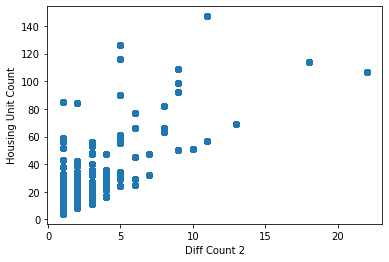

In [ ]:
# Difference in Count for Blocks with fewer AP than Housing Units
x = building_gdf_round2_v3['DiffCount2'].loc[(building_gdf_round2_v3['ErrorCheck2']=="4. HU>AP")]
y = building_gdf_round2_v3['apcount'].loc[(building_gdf_round2_v3['ErrorCheck2']=="4. HU>AP")]
plt.scatter(x, y)
plt.xlabel("Diff Count 2")
plt.ylabel("Housing Unit Count")

In [ ]:
# Create Round 3 version of Address Point Estiamte
building_gdf_round3_v1 = building_gdf_round2_v3
building_gdf_round3_v1['residentialAP3v1'] = building_gdf_round3_v1['residentialAP2v2']

In [ ]:
building_gdf_round3_v1['residentialAP3v1'].loc[(building_gdf_round3_v1['ErrorCheck2']=="4. HU>AP")].describe()

count    6010.000000
mean        1.033278
std         0.527390
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: residentialAP3v1, dtype: float64

In [ ]:
building_gdf_round3_v1.loc[(building_gdf_round3_v1['ErrorCheck2']=="4. HU>AP") &
                          (building_gdf_round2_v3['residentialAP2v2']>=1),
                           'residentialAP3v1'] = building_gdf_round3_v1['residentialAP3v1'] + 1
building_gdf_round3_v1['residentialAP3v1'].loc[(building_gdf_round3_v1['ErrorCheck2']=="4. HU>AP")].describe()

count    6010.000000
mean        1.970050
std         0.684154
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        10.000000
Name: residentialAP3v1, dtype: float64

## Sum Residential Addresspoints (third attempt) by blockid

In [ ]:
# sum Buildings over the column BLOCKID.
# https://www.geeksforgeeks.org/python-pandas-dataframe-sum/
block_rap3_gdf = building_gdf_round3_v1[['BLOCKID10','residentialAP3v1']]
block_rap3_gdf['bldgcountv3'] = 1
block_rap3_gdf_sum = block_rap3_gdf.groupby(['BLOCKID10']).sum()
block_rap3_gdf_sum.head()

C:\Users\nathanael99\AppData\Local\Continuum\anaconda3\envs\pyincoreEnv20210301\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,residentialAP3v1,bldgcountv3
BLOCKID10,,
371559601024055,20.0,1
371559604022066,6.0,6
371559605031030,17.0,17
371559605031031,23.0,12
371559605031036,12.0,16


In [ ]:
block_rap3_gdf_sum['residentialAP3v1'].describe()

count    1572.000000
mean       16.641221
std        26.211616
min         0.000000
25%         2.000000
50%         8.000000
75%        19.000000
max       270.000000
Name: residentialAP3v1, dtype: float64

## Error Check Round 3

In [ ]:
census_blocks_df_rap2['BLOCKID10'].describe()

count    5.799000e+03
mean     3.715596e+14
std      6.468066e+06
min      3.715596e+14
25%      3.715596e+14
50%      3.715596e+14
75%      3.715596e+14
max      3.715596e+14
Name: BLOCKID10, dtype: float64

In [ ]:
# Merge Sum of Residential Address Points with Census Counts
census_blocks_df_rap3 = pd.merge(census_blocks_df_rap2, block_rap3_gdf_sum,
                                  left_on='BLOCKID10', right_on='BLOCKID10', how='left')
census_blocks_df_rap3['BLOCKID10'].describe()

count    5.799000e+03
mean     3.715596e+14
std      6.468066e+06
min      3.715596e+14
25%      3.715596e+14
50%      3.715596e+14
75%      3.715596e+14
max      3.715596e+14
Name: BLOCKID10, dtype: float64

In [ ]:
block_error_check_addresspoints(census_blocks_df_rap3,'tothupoints','residentialAP3v1','bldgcountv3','ErrorCheck3')
pd.crosstab(census_blocks_df_rap3['ErrorCheck2'], census_blocks_df_rap3['ErrorCheck3'], margins=True, margins_name="Total")

ErrorCheck3,0. Not Checked,2. HU=AP,3. HU<AP,"5. HU > 0, AP = 0","8. HU > 0, Building Count = Missing",Total
ErrorCheck2,,,,,,
0. Not Checked,1476,0,0,0,0,1476
2. HU=AP,0,753,0,0,0,753
3. HU<AP,0,0,502,0,0,502
4. HU>AP,0,0,316,0,0,316
"5. HU > 0, AP = 0",0,0,0,1,0,1
"8. HU > 0, Building Count = Missing",0,0,0,0,2751,2751
Total,1476,753,818,1,2751,5799


In [ ]:
pd.crosstab(census_blocks_df_rap3['ErrorCheck3'], census_blocks_df_rap3['Lumberton'], margins=True, margins_name="Total")

Lumberton,Lumberton,Not Lumberton,Total
ErrorCheck3,,,
0. Not Checked,181,1295,1476
2. HU=AP,478,275,753
3. HU<AP,374,444,818
"5. HU > 0, AP = 0",1,0,1
"8. HU > 0, Building Count = Missing",13,2738,2751
Total,1047,4752,5799


In [ ]:
pd.crosstab(building_gdf_round3_v1['residentialAP3v1'], building_gdf_round3_v1['archetype'], margins=True, margins_name="Total")

archetype,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Total
residentialAP3v1,,,,,,,,,,,,,,,,,
0.0,25,103,84,0,5,1014,9,10,12,146,84,3,23,191,128,372,2209
1.0,0,3865,6432,161,646,31,0,0,0,1,0,0,0,2,32,1,11171
2.0,0,1991,3308,76,587,14,0,0,1,2,0,0,0,2,2,0,5983
3.0,0,81,300,8,78,1,0,0,0,0,0,0,0,0,0,0,468
4.0,0,14,65,2,21,0,0,0,0,0,0,0,0,0,0,0,102
5.0,0,2,33,0,22,0,0,0,0,0,0,0,0,0,0,0,57
6.0,0,2,16,1,14,0,0,0,0,0,0,0,0,0,0,0,33
7.0,0,2,10,0,12,0,0,0,0,0,0,0,0,0,0,0,24
8.0,0,1,12,0,2,0,0,0,0,0,0,1,0,0,0,0,16


### Look at outliers in Archtype and Estimated counts

In [ ]:
displaycols = ['BLOCKID10','guid','archetype','PLCNAME10','COUNTYFP10','bldgcount1_sum','residentialAP3v1']
condition = building_gdf_round3_v1['residentialAP3v1']> 24
building_gdf_round3_v1[displaycols].loc[condition].sort_values(by=['residentialAP3v1'])

,BLOCKID10,guid,archetype,PLCNAME10,COUNTYFP10,bldgcount1_sum,residentialAP3v1
101,371559615004040,bad08571-725f-492b-b862-81828644e417,1,NaN,155.0,1.0,25.0
5828,371559608011031,eeaa1251-9404-44f8-9c91-4ec170078348,2,Lumberton,155.0,2.0,38.0
5829,371559608011031,ffa72530-7ac7-46f1-9cc9-7950b250e870,2,Lumberton,155.0,2.0,41.0


In [ ]:
blocklist = building_gdf_round3_v1.BLOCKID10.loc[condition].unique()
blocklist

array([371559615004040, 371559608011031], dtype=int64)

In [ ]:
# Read in block data
source_program = 'IN-CORE_1av2_Lumberton_CleanBlockData_2021-04-15'
census_blocks_csv = source_program+"/"+source_program+"EPSG4269.csv"
census_blocks_df = pd.read_csv(census_blocks_csv)
census_blocks_gdf = gpd.GeoDataFrame(census_blocks_df)
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.wkt import loads

census_blocks_gdf['geometry'] = census_blocks_gdf['geometry'].apply(lambda x: loads(x))
census_blocks_gdf['geometry'].geom_type.describe()
census_blocks_gdf = census_blocks_gdf.set_geometry(census_blocks_gdf['geometry'])
census_blocks_gdf.crs = {'init':'epsg:4269'}

In [ ]:
census_select_block_gdf = census_blocks_gdf.loc[(census_blocks_gdf['BLOCKID10'].isin(blocklist))]
census_select_block_gdf

,Unnamed: 0,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,...,blockid,tothupoints,popcount,HU100,POP100,popdiff,PLCGEOID10,PLCNAME10,PUMGEOID10,PUMNAME10
555,555,37,155,961500,4040,371559615004040,N,25,52,"POLYGON ((-78.91644 34.53518, -78.91592 34.532...",...,371559615004040,25,52,25,52,0,NaN,NaN,3704900,"Columbus, Bladen & Robeson (East) Counties PUMA"
1407,1407,37,155,960801,1031,371559608011031,N,79,82,"POLYGON ((-79.02843 34.60738, -79.02832 34.607...",...,371559608011031,79,82,79,82,0,3739700.0,Lumberton,3705100,Robeson County (West)--Lumberton City PUMA


In [ ]:
building_select_gdf = building_gdf_round3_v1.loc[(building_gdf_round3_v1['BLOCKID10'].isin(blocklist))]
building_select_gdf[['BLOCKID10','geometry','PLCNAME10','residentialAP3v1']]

,BLOCKID10,geometry,PLCNAME10,residentialAP3v1
101,371559615004040,POINT (-78.94398 34.54999),NaN,25.0
5828,371559608011031,POINT (-79.02792 34.60589),Lumberton,38.0
5829,371559608011031,POINT (-79.02856 34.60693),Lumberton,41.0


In [ ]:
# if there are missing buildings this code will help identify where they are - every building should have a block
# plot the building with missing block data
# Find the bounds of the Census Block File
minx = building_gdf_round3_v1.bounds.minx.min()
miny = building_gdf_round3_v1.bounds.miny.min()
maxx = building_gdf_round3_v1.bounds.maxx.max()
maxy = building_gdf_round3_v1.bounds.maxy.max()

blockstyle_function = lambda x: {'color':'green','fillColor': 'transparent' }

bldg_inv_gdf_map = fm.Map(location=[(miny+maxy)/2,(minx+maxx)/2], zoom_start=10)
fm.GeoJson(building_select_gdf).add_to(bldg_inv_gdf_map)
fm.GeoJson(census_select_block_gdf['geometry'],name='Selected Census Blocks').add_to(bldg_inv_gdf_map)
bldg_inv_gdf_map.save(programname+'buildings_addpt_outliers.html')
display(bldg_inv_gdf_map)

In [ ]:
# Save Work at this point - Save as CSV
savefile = sys.path[0]+"/"+programname+"/"+programname+"_huestimate_EPSG4326.csv"
building_gdf_round3_v1.to_csv(savefile)